In [1]:

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.collections import PathCollection
from matplotlib.patheffects import withStroke
import os
from datetime import datetime
import cartopy.mpl.ticker              as ctk
import matplotlib.ticker as mticker
import cmaps 


In [4]:
#%% ----- Parameter setting ------
ystr = 1989
yend = 2011


latS = -90.
latN = 90.
lonW = 0.
lonE = 360


print("当前目录:", os.getcwd())
# == Figure name ==
# fnFIG = os.path.splitext(os.path.basename(__file__))[0]

# == netcdf file name and location"
fnc = 'I:/oisst_monthly.nc'
dmask = xr.open_dataset('I:/lsmask.nc')
print(dmask)

ds = xr.open_dataset(fnc)
print(ds)

当前目录: m:\公众号\ipynb_汇总
<xarray.Dataset> Size: 261kB
Dimensions:  (lat: 180, lon: 360, time: 1)
Coordinates:
  * lat      (lat) float32 720B 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 8B 1981-10-29
Data variables:
    mask     (time, lat, lon) float32 259kB ...
Attributes:
    title:          NOAA Optimum Interpolation (OI) SST V2
    Conventions:    CF-1.0
    history:        Created 10/2002 by RHS
    comments:       Data described in  Reynolds, R.W., N.A. Rayner, T.M.\nSmi...
    platform:       Model
    source:         NCEP Climate Modeling Branch
    institution:    National Centers for Environmental Prediction
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Optimum Interpolation (OI) SST V2
    source_url:     http://www.emc.ncep.noaa.gov/research/cmb/sst_analysis/
<xarray.Dataset> Size: 123MB
Dimensions:  

In [5]:

# === Climatology and Anomalies
sst = ds.sst.where(dmask.mask.isel(time=0) == 1)
clm = sst.sel(time=slice(str(ystr),str(yend))).groupby('time.month').mean(dim='time')
anm = (sst.groupby('time.month') - clm)
#print(clm)
# -- Detorending
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

def cal_nino34(ds,lat1,lat2,lon1,lon2):
    ds = ds.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
    clm = ds.groupby('time.month').mean(dim='time')
    an_ds = ds.groupby('time.month') - clm
    an_ds = an_ds.mean(('lon','lat'))
    an_ds = detrend_dim(an_ds,dim='time',deg=1)
    return an_ds


In [6]:

# -- regional average
def wgt_areaave(indat, latS, latN, lonW, lonE):
  lat=indat.lat
  lon=indat.lon

  if ( ((lonW < 0) or (lonE < 0 )) and (lon.values.min() > -1) ):
     anm=indat.assign_coords(lon=( (lon + 180) % 360 - 180) )
     lon=( (lon + 180) % 360 - 180)
  else:
     anm=indat

  iplat = lat.where( (lat >= latS ) & (lat <= latN), drop=True)
  iplon = lon.where( (lon >= lonW ) & (lon <= lonE), drop=True)

  print(iplat)
  print(iplon)
  wgt = np.cos(np.deg2rad(lat))
  odat=anm.sel(lat=iplat,lon=iplon).weighted(wgt).mean(("lon", "lat"), skipna=True)
  return(odat)

<xarray.DataArray 'lat' (lat: 10)> Size: 40B
array([ 4.5,  3.5,  2.5,  1.5,  0.5, -0.5, -1.5, -2.5, -3.5, -4.5],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 40B 4.5 3.5 2.5 1.5 0.5 -0.5 -1.5 -2.5 -3.5 -4.5
Attributes:
    units:               degrees_north
    long_name:           Latitude
    actual_range:        [ 89.5 -89.5]
    standard_name:       latitude
    axis:                Y
    coordinate_defines:  center
<xarray.DataArray 'lon' (lon: 50)> Size: 200B
array([-169.5, -168.5, -167.5, -166.5, -165.5, -164.5, -163.5, -162.5,
       -161.5, -160.5, -159.5, -158.5, -157.5, -156.5, -155.5, -154.5,
       -153.5, -152.5, -151.5, -150.5, -149.5, -148.5, -147.5, -146.5,
       -145.5, -144.5, -143.5, -142.5, -141.5, -140.5, -139.5, -138.5,
       -137.5, -136.5, -135.5, -134.5, -133.5, -132.5, -131.5, -130.5,
       -129.5, -128.5, -127.5, -126.5, -125.5, -124.5, -123.5, -122.5,
       -121.5, -120.5], dtype=float32)
Coordinates:
  * lon      (lon) float32 200B 190.

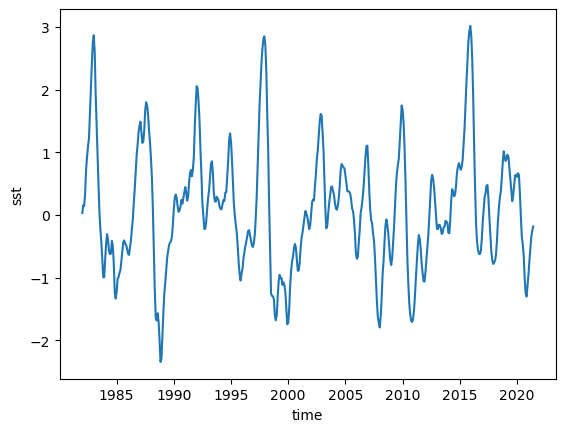

In [7]:

# -- Calculate nino3.4 index
nino=wgt_areaave(anm,-5,5,-170,-120)
ninoSD=nino/nino.std(dim='time')
rninoSD=ninoSD.rolling(time=3, center=True).mean('time')
rninoSD.plot()


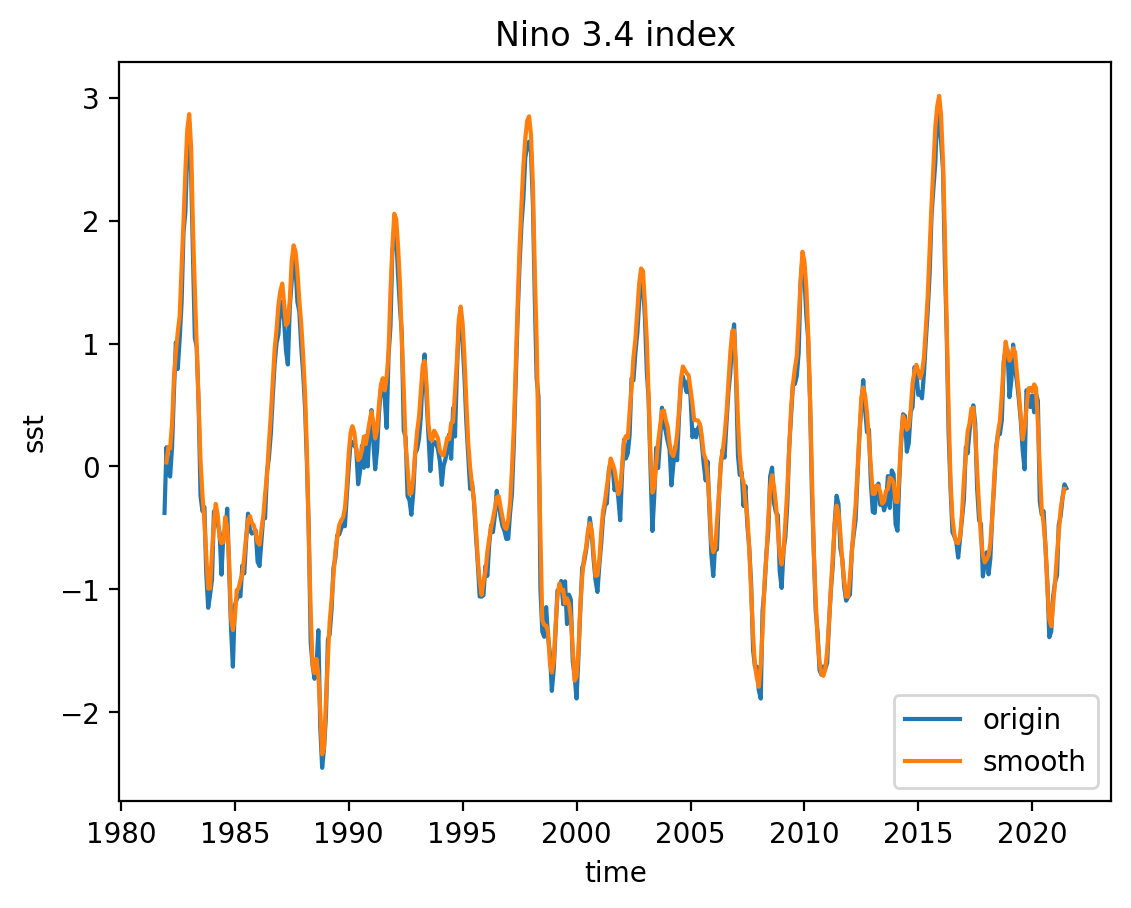

In [8]:


nino3_4 = cal_nino34(sst,5,-5,190,240)
plt.figure(dpi=200)
nino3_4.plot(label='origin')
rninoSD.plot(label='smooth')
plt.title('Nino 3.4 index')
plt.legend()


In [9]:
# -- Running mean
ranm = anm.rolling(time=3, center=True).mean('time')
rdanm = detrend_dim(ranm,'time',1)

In [10]:
#%% -- Correlation & Regression


# Leading
corM12 = xr.corr(rninoSD, rdanm.shift(time=-12), dim="time")
regM12 = xr.cov( rninoSD, rdanm.shift(time=-12), dim="time")/rninoSD.var(dim='time',skipna=True).values
corM6 = xr.corr(rninoSD, rdanm.shift(time=-6), dim="time")
regM6 = xr.cov( rninoSD, rdanm.shift(time=-6), dim="time")/rninoSD.var(dim='time',skipna=True).values

# simultaneous
cor0 = xr.corr(rninoSD, rdanm, dim="time")
reg0 = xr.cov(rninoSD, rdanm, dim="time")/rninoSD.var(dim='time',skipna=True).values

# Laging
corP6 = xr.corr(rninoSD, rdanm.shift(time=6), dim="time")
regP6 = xr.cov( rninoSD, rdanm.shift(time=6), dim="time")/rninoSD.var(dim='time',skipna=True).values
corP12 = xr.corr(rninoSD, rdanm.shift(time=12), dim="time")
regP12 = xr.cov( rninoSD, rdanm.shift(time=12), dim="time")/rninoSD.var(dim='time',skipna=True).values
corP18 = xr.corr(rninoSD, rdanm.shift(time=18), dim="time")
regP18 = xr.cov( rninoSD, rdanm.shift(time=18), dim="time")/rninoSD.var(dim='time',skipna=True).values


d:\anaconda\ANACONDA\envs\pji\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\anaconda\ANACONDA\envs\pji\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\anaconda\ANACONDA\envs\pji\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\anaconda\ANACONDA\envs\pji\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\anaconda\ANACONDA\envs\pji\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\anaconda\ANACONDA\envs\pji\Lib\s

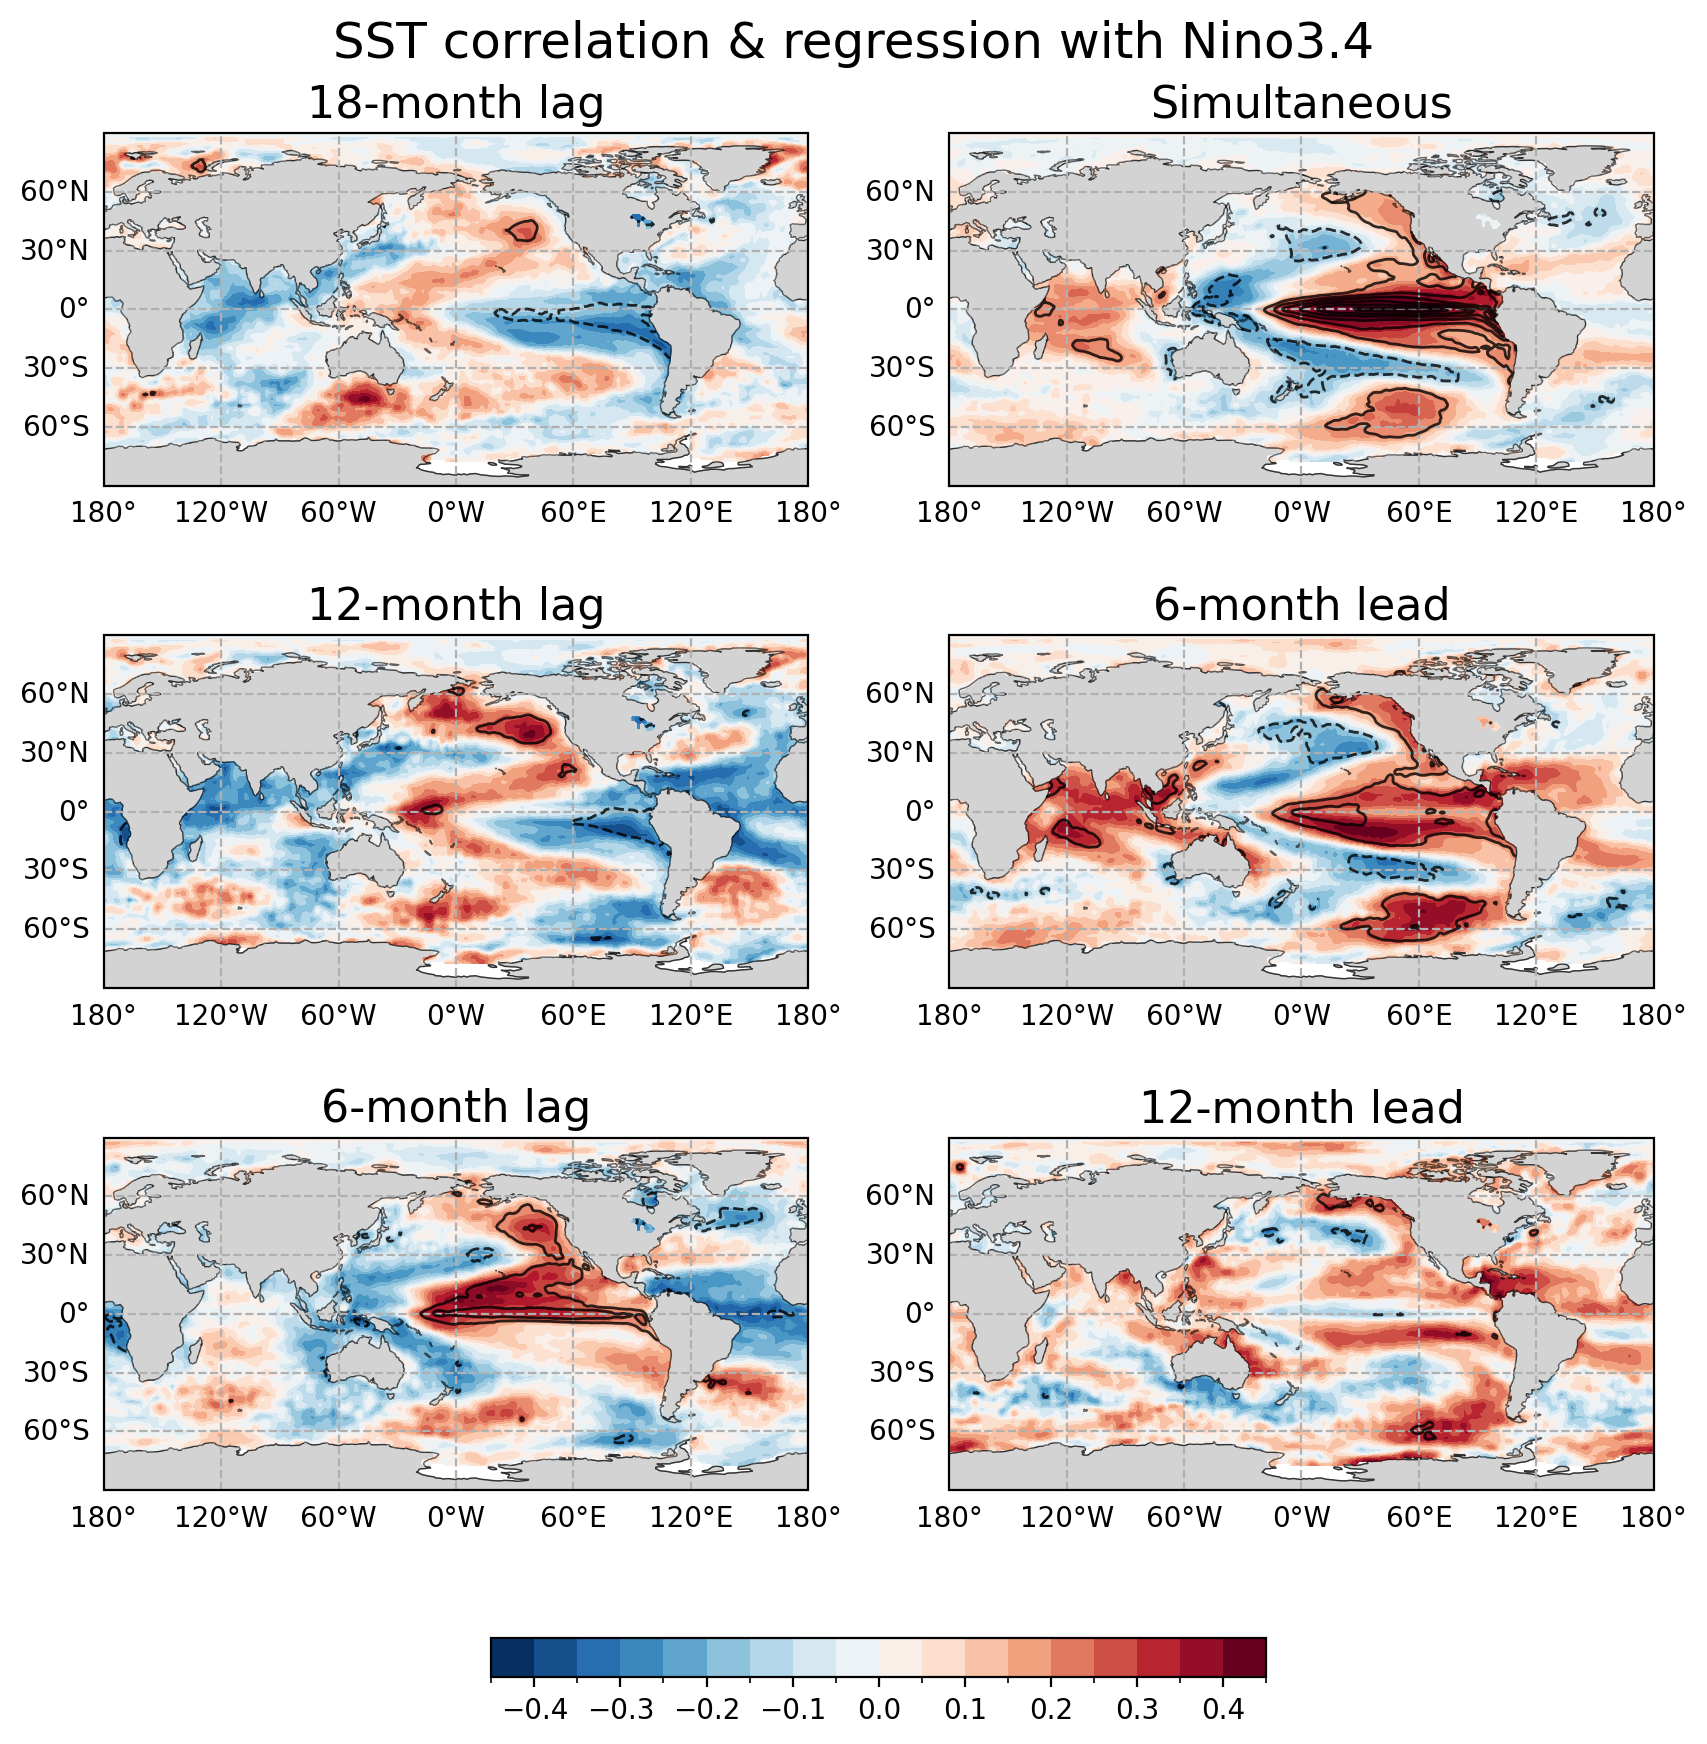

In [12]:
#%% -- figure plot




def makefig(cor, reg, title, grid_space, fig):
    # Generate axes using Cartopy to draw coastlines
    ax = fig.add_subplot(grid_space, projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines(linewidth=0.5, alpha=0.6)

    # Set axes limits & tick values
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    # ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
    # ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
    # ax.xaxis.set_major_formatter(LongitudeFormatter())
    # ax.yaxis.set_major_formatter(LatitudeFormatter())
    # ax.gridlines()
    gl=ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, linestyle='dashed',
                    crs=ccrs.PlateCarree(central_longitude=180))
    gl.top_labels=False
    gl.right_labels=False
    gl.rotate_labels=False
    gl.xlocator=ctk.LongitudeLocator(10)
    gl.ylocator=ctk.LatitudeLocator(8)
    gl.xformatter=ctk.LongitudeFormatter(zero_direction_label=True)
    gl.yformatter=ctk.LatitudeFormatter()
    gl.xlocator = mticker.FixedLocator(np.linspace(-180, 180, 7))
    # Add minor and major tick lines
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(30))
    # ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    # ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))

    # Make latitude, longitude tick labels
    ax.tick_params(labelsize=10)
    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
    ax.add_feature(cfeature.COASTLINE, edgecolor='gray', linewidth=0.5, zorder=1)

    # Contourf-plot data
    fillplot = cor.plot.contourf(ax=ax, 
                                 levels=21, 
                                 transform=ccrs.PlateCarree(),
                                 add_colorbar=False)

    # Plot line contours
    delc = 0.2
    levels = np.arange(-3, 0, delc)
    levels = np.append(levels, np.arange(delc, 3, delc))
    rad = reg.plot.contour(ax=ax, colors='black',
                           alpha=0.8, 
                           linewidths=1.0, 
                           levels=levels, 
                           transform=ccrs.PlateCarree())
    # pe = [PathEffects.withStroke(linewidth=2.0, foreground="w")]
    # plt.setp(rad.collections, path_effects=pe)

    pe = [withStroke(linewidth=2.0, foreground="w")]
    
    # 检查集合是否为 PathCollection 类型
    if isinstance(rad, PathCollection):
        rad.set_path_effects(pe)
    else:
        # 循环遍历集合中的每个元素并为其应用路径效果
        for artist in rad.get_children():
            if isinstance(artist, PathCollection):
                artist.set_path_effects(pe)

   
    # Set titles and labels
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    return ax, fillplot

# Create the figure
fig = plt.figure(figsize=(10, 12), dpi=200)
grid = fig.add_gridspec(ncols=2, nrows=3)

# Make the plots
ax1, fill1 = makefig(corP18, regP18, '18-month lag', grid[0, 0], fig)
ax2, fill2 = makefig(corP12, regP12, '12-month lag', grid[1, 0], fig)
ax3, fill3 = makefig(corP6, regP6, '6-month lag', grid[2, 0], fig)
ax4, fill4 = makefig(cor0, reg0, 'Simultaneous', grid[0, 1], fig)
ax5, fill5 = makefig(corM6, regM6, '6-month lead', grid[1, 1], fig)
ax6, fill6 = makefig(corM12, regM12, '12-month lead', grid[2, 1], fig)

# Add colorbar
cbar = fig.colorbar(fill6, ax=[ax1, ax2, ax3, ax4, ax5, ax6], 
                    orientation='horizontal', 
                    shrink=0.5, pad=0.08)

fig.suptitle('SST correlation & regression with Nino3.4', fontsize=18, y=0.9)
plt.draw()
# Show the plot
plt.show()


# plt.savefig(fnFIG+".png")
# plt.savefig(fnFIG+".pdf")
# plt.savefig(fnFIG+".eps", format='eps')
